# Predicción del valor de coches

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, es posible averiguar rápidamente el valor de mercado de un coche. Mediante los datos históricos sobre especificaciones técnicas, versiones de equipamiento y precios, se desarrollará un modelo que determine el valor de mercado de los coches.
A Rusty Bargain le interesa:
- la calidad de la predicción
- la velocidad de la predicción
- el tiempo requerido para el entrenamiento

**Tabla de contenidos**<a id='toc0_'></a>    
- [Importación de librerías y lectura de datos](#toc1_)    
- [Preparación de datos](#toc2_)    
  - [Duplicados](#toc2_1_)    
  - [Columnas innecesarias](#toc2_2_)    
  - [Posibles valores incorrectos y valores atípicos](#toc2_3_)    
  - [Valores ausentes](#toc2_4_)    
- [Entrenamiento del modelo](#toc3_)    
  - [Regresión lineal](#toc3_1_)    
  - [Random Forest](#toc3_2_)    
  - [LightGBM](#toc3_3_)    
- [Análisis de modelos](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Importación de librerías y lectura de datos](#toc0_)

In [323]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, make_scorer
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

In [264]:
try:
    cars = pd.read_csv('./datasets/car_data.csv')
except:
    cars = pd.read_csv('/datasets/car_data.csv')

cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [265]:
cars.shape

(354369, 16)

In [266]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [267]:
cars.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


De la inspección general del dataframe se puede comentar lo siguiente:
- El conjunto de datos cuenta con 354 396 registros y 16 columnas, de las cuales 6 columnas presentan valores ausentes en sus filas.
- Para efectos de este estudio, se eliminarán columnas que no son relevantes para el análisis. 

En cuanto a la descripción de las variables numéricas, se destaca lo siguiente: 
1) Existen valores de `price` que son iguales a cero, lo cual puede ser un error de captura de datos o que el auto tenga tan mal estado que su valor sea cero.
2) En la columna `registrationyear` se observan valores de 1000 y 9999, los cuales no son consistentes con este tipo de variable.
3) El valor máximo en `powerps` de 20000 es demasiado alto para los rangos típicos de potencia de un auto, por lo que se considera un error de captura de datos. Por otro lado, el valor mínimo de 0 podría ser también un error o indicar que el auto no tiene motor.
4) La mediana de la columna `mileage` de 150 000 es igual al percentil 75 y al valor máximo. Probablemente esto se deba a que 150 000 sea el límite superior para el sistema de registro, por lo que los automóviles con este valor podrían tener un kilometraje mayor.
5) La columna `registrationmonth` tiene valores de 0, lo cual no es consistente con el rango de meses del año.

## <a id='toc2_'></a>[Preparación de datos](#toc0_)

In [268]:
# Minúsculas en todas las columnas 
cars.columns = cars.columns.str.lower()

### <a id='toc2_1_'></a>[Duplicados](#toc0_)

In [269]:
# Revisión de duplicados
print('Total de duplicados en el dataset: ', cars.duplicated().sum())
print(f'Porcentaje del dataset: {cars.duplicated().sum() / len(cars):.2%}')
cars[cars.duplicated(keep=False)].head(10)

Total de duplicados en el dataset:  262
Porcentaje del dataset: 0.07%


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
183,21/03/2016 19:06,5999,small,2009,manual,80,polo,125000,5,petrol,volkswagen,no,21/03/2016 00:00,0,65529,05/04/2016 20:47
1771,06/04/2016 21:25,3900,sedan,1999,manual,116,beetle,150000,6,petrol,volkswagen,no,06/04/2016 00:00,0,55469,06/04/2016 21:25
1910,05/04/2016 00:59,2400,sedan,2002,auto,133,other,150000,12,gasoline,peugeot,no,04/04/2016 00:00,0,15517,05/04/2016 08:41
2267,13/03/2016 20:48,4200,sedan,2003,manual,105,golf,150000,10,gasoline,volkswagen,no,13/03/2016 00:00,0,14482,13/03/2016 20:48
3176,23/03/2016 21:25,900,bus,1995,manual,110,transporter,150000,9,petrol,volkswagen,yes,23/03/2016 00:00,0,65239,30/03/2016 10:17
3472,02/04/2016 16:53,1250,sedan,1993,manual,150,3er,150000,6,petrol,bmw,no,02/04/2016 00:00,0,54317,06/04/2016 16:15
3783,30/03/2016 17:51,15000,small,2013,manual,86,a1,50000,12,petrol,audi,no,30/03/2016 00:00,0,83703,07/04/2016 08:45
3857,20/03/2016 15:25,3400,bus,2005,manual,120,scenic,150000,6,gasoline,renault,no,20/03/2016 00:00,0,63303,27/03/2016 07:16
3889,05/03/2016 14:18,6300,bus,2006,manual,140,touran,150000,4,gasoline,volkswagen,no,03/03/2016 00:00,0,56567,06/03/2016 03:16
4072,27/03/2016 11:58,8290,convertible,2000,auto,218,slk,150000,5,petrol,mercedes_benz,no,27/03/2016 00:00,0,79206,01/04/2016 11:18


Se decide eliminar los duplicados puesto que la información de fecha y hora de las columnas podría indicar que son duplicados verdaderos.

In [270]:
# Eliminación de duplicados 
cars = cars.drop_duplicates()

### <a id='toc2_2_'></a>[Columnas innecesarias](#toc0_)

Aparte de la verificación de duplicados, se considera que las columnas datetime no son relevantes para el análisis, por lo que se eliminan. Por el mismo motivo, se eliminan `numberofpictures` y `postalcode`.

In [271]:
# Eliminación de columnas no necesarias
cars.drop(columns = ['datecrawled', 'datecreated', 'lastseen', 'numberofpictures', 'postalcode'], inplace=True) 

### <a id='toc2_3_'></a>[Posibles valores incorrectos y valores atípicos](#toc0_)

Se inicia identificando posibles valores incorrectos en las variables de tipo numérico.

In [272]:
# función para graficar columnas individualmente
def plot_hist_n_boxplot(df, column):
    # Creo la matriz de gráficos
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))


    axes[0].hist(df[column], bins=200)
    axes[0].set_xlabel(column.capitalize())
    axes[0].set_ylabel("Frequency")
    axes[0].set_title(f"Histogram of {column.capitalize().replace('_',' ')}")
    axes[0].set_xlim(df[column].min(), np.quantile(df[column], 0.9999))

    # Gráfico de caja en la segunda columna
    boxplot = axes[1].boxplot(df[column], boxprops={'color':'blue'}, whiskerprops={'color':'red'})
    axes[1].set_ylabel(column.capitalize())
    axes[1].set_title(f"Boxplot of {column.capitalize().replace('_',' ')}")
    axes[1].set_xticklabels([])
    axes[1].set_xlabel(column.capitalize())  

    plt.subplots_adjust(hspace=0.4)


    plt.show()

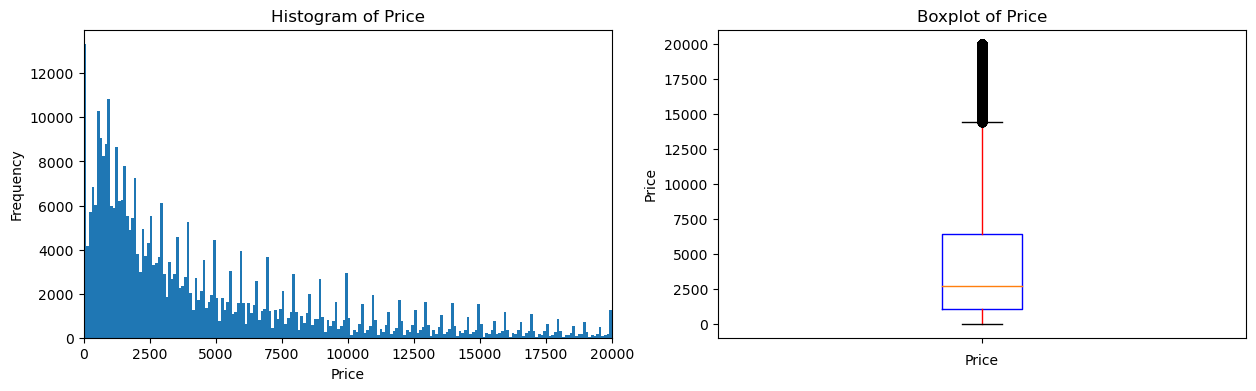

In [273]:
# Graficos de price
plot_hist_n_boxplot(cars, 'price')

In [274]:
print('Conteo de los veinte primeros valores de price:')
print(cars['price'].value_counts().sort_index().head(20))

Conteo de los veinte primeros valores de price:
0     10770
1      1188
2        12
3         8
4         1
5        26
7         3
8         9
9         8
10       84
11        5
12        8
13        7
14        5
15       27
16        2
17        5
18        3
19        3
20       51
Name: price, dtype: int64


Se observa un elevado número de valores de `price` iguales a 0 y 1. Puesto que no se dispone de información sobre el significado de estos valores, se decide eliminarlos. 

In [275]:
# Se remueven los vehículos cuyo precio es igual a cero y uno
cars_filtered = cars[(cars['price'] != 0) & (cars['price'] != 1)]

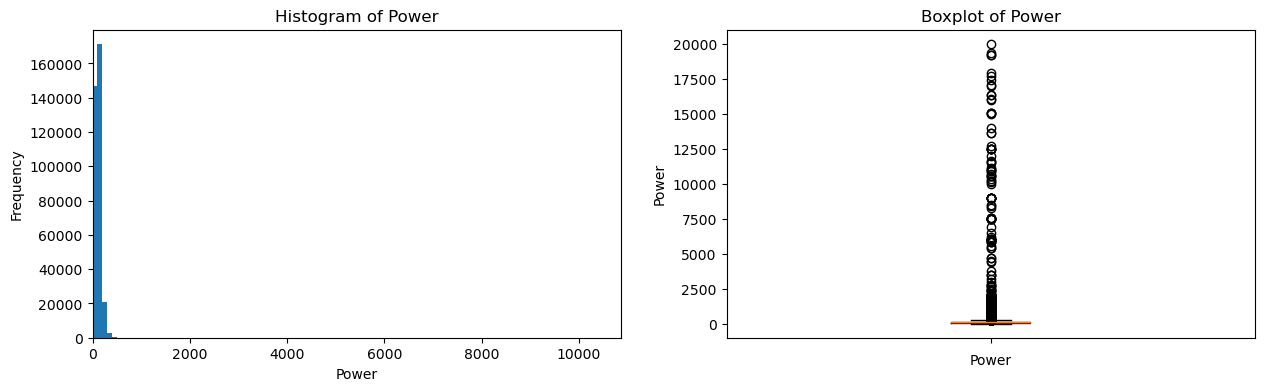

In [276]:
# Graficos de power
plot_hist_n_boxplot(cars_filtered, 'power')

In [277]:
print('Conteo de los veinte primeros valores de power:')
print(cars_filtered['power'].value_counts().sort_index().head(20))

Conteo de los veinte primeros valores de power:
0     35872
1        25
2         9
3         9
4        30
5       100
6        11
7        10
8         7
9         5
10       12
11       28
12       18
13        8
14       20
15       19
16       11
17        8
18       50
19       14
Name: power, dtype: int64


Nuevamente, se procede a eliminar los valores de 0.

In [278]:
# Se remueven los vehículos cuya potencia es igual a cero
cars_filtered = cars_filtered.loc[cars_filtered['power'] > 0]
cars_filtered.reset_index(drop=True, inplace=True)	

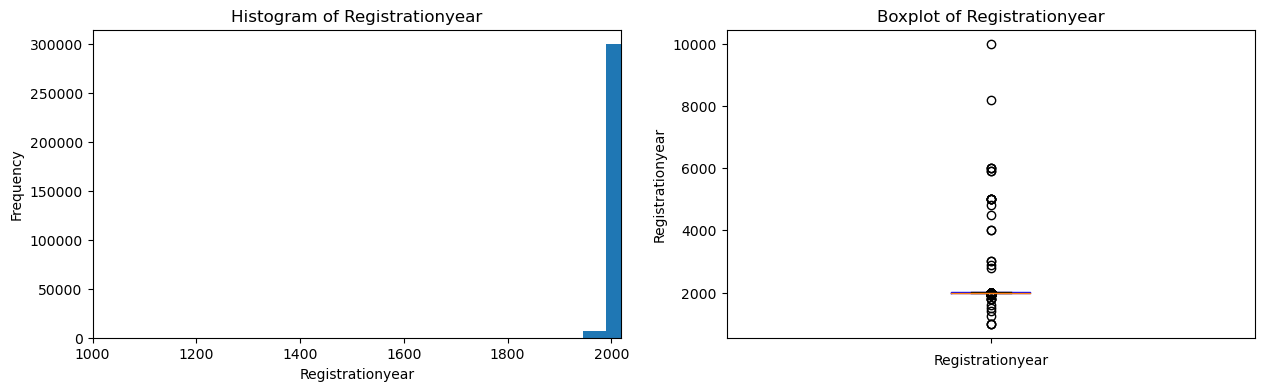

In [279]:
# Graficos de registrationyear
plot_hist_n_boxplot(cars_filtered, 'registrationyear')

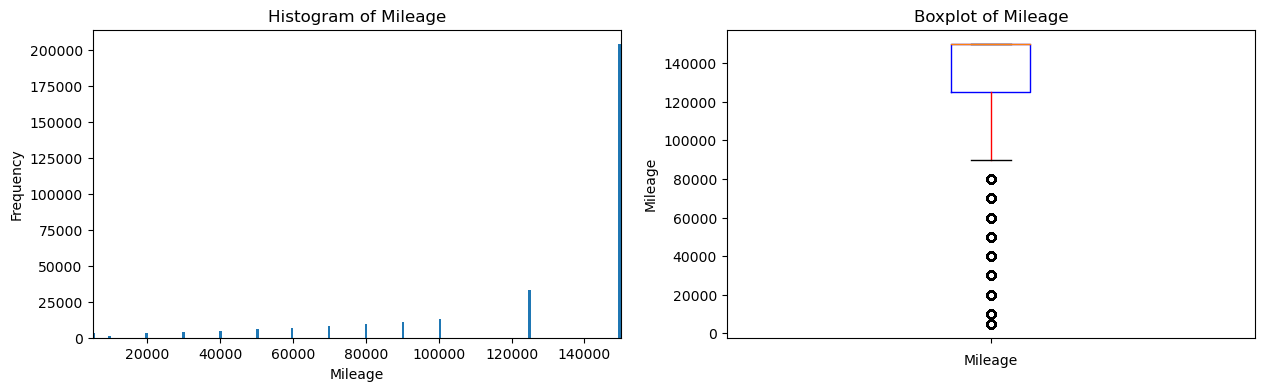

In [280]:
# Graficos de mileage
plot_hist_n_boxplot(cars_filtered, 'mileage')

Hasta ahora, se han removido registros con valores de `price` y `power` que son considerados como atípicos y de los cuales no se dispone de suficiente información para determinar si son correctos o no. Se ha decidido eliminarlos para evitar que afecten el análisis de los datos. También, estas columnas junto con las columnas de `registrationyear` y `mileage` presentan valores extremos altos como bajos, los cuales serán removidos para evitar que afecten el análisis de los datos.

In [281]:
# función para remover outliers
def remove_outliers(df, columns):
    for col in columns:
        iqr = stats.iqr(df[col])
        q1, q3 = np.percentile(df[col], [25, 75])
        df = df[(df[col] >= q1 - 1.5*iqr) & (df[col] <= q3 + 1.5*iqr)]
    return df

In [282]:
# Se aplica la función a las variables numéricas
colums_with_outliers = ['price', 'registrationyear', 'power', 'mileage']

cars_filtered = remove_outliers(cars_filtered, colums_with_outliers)

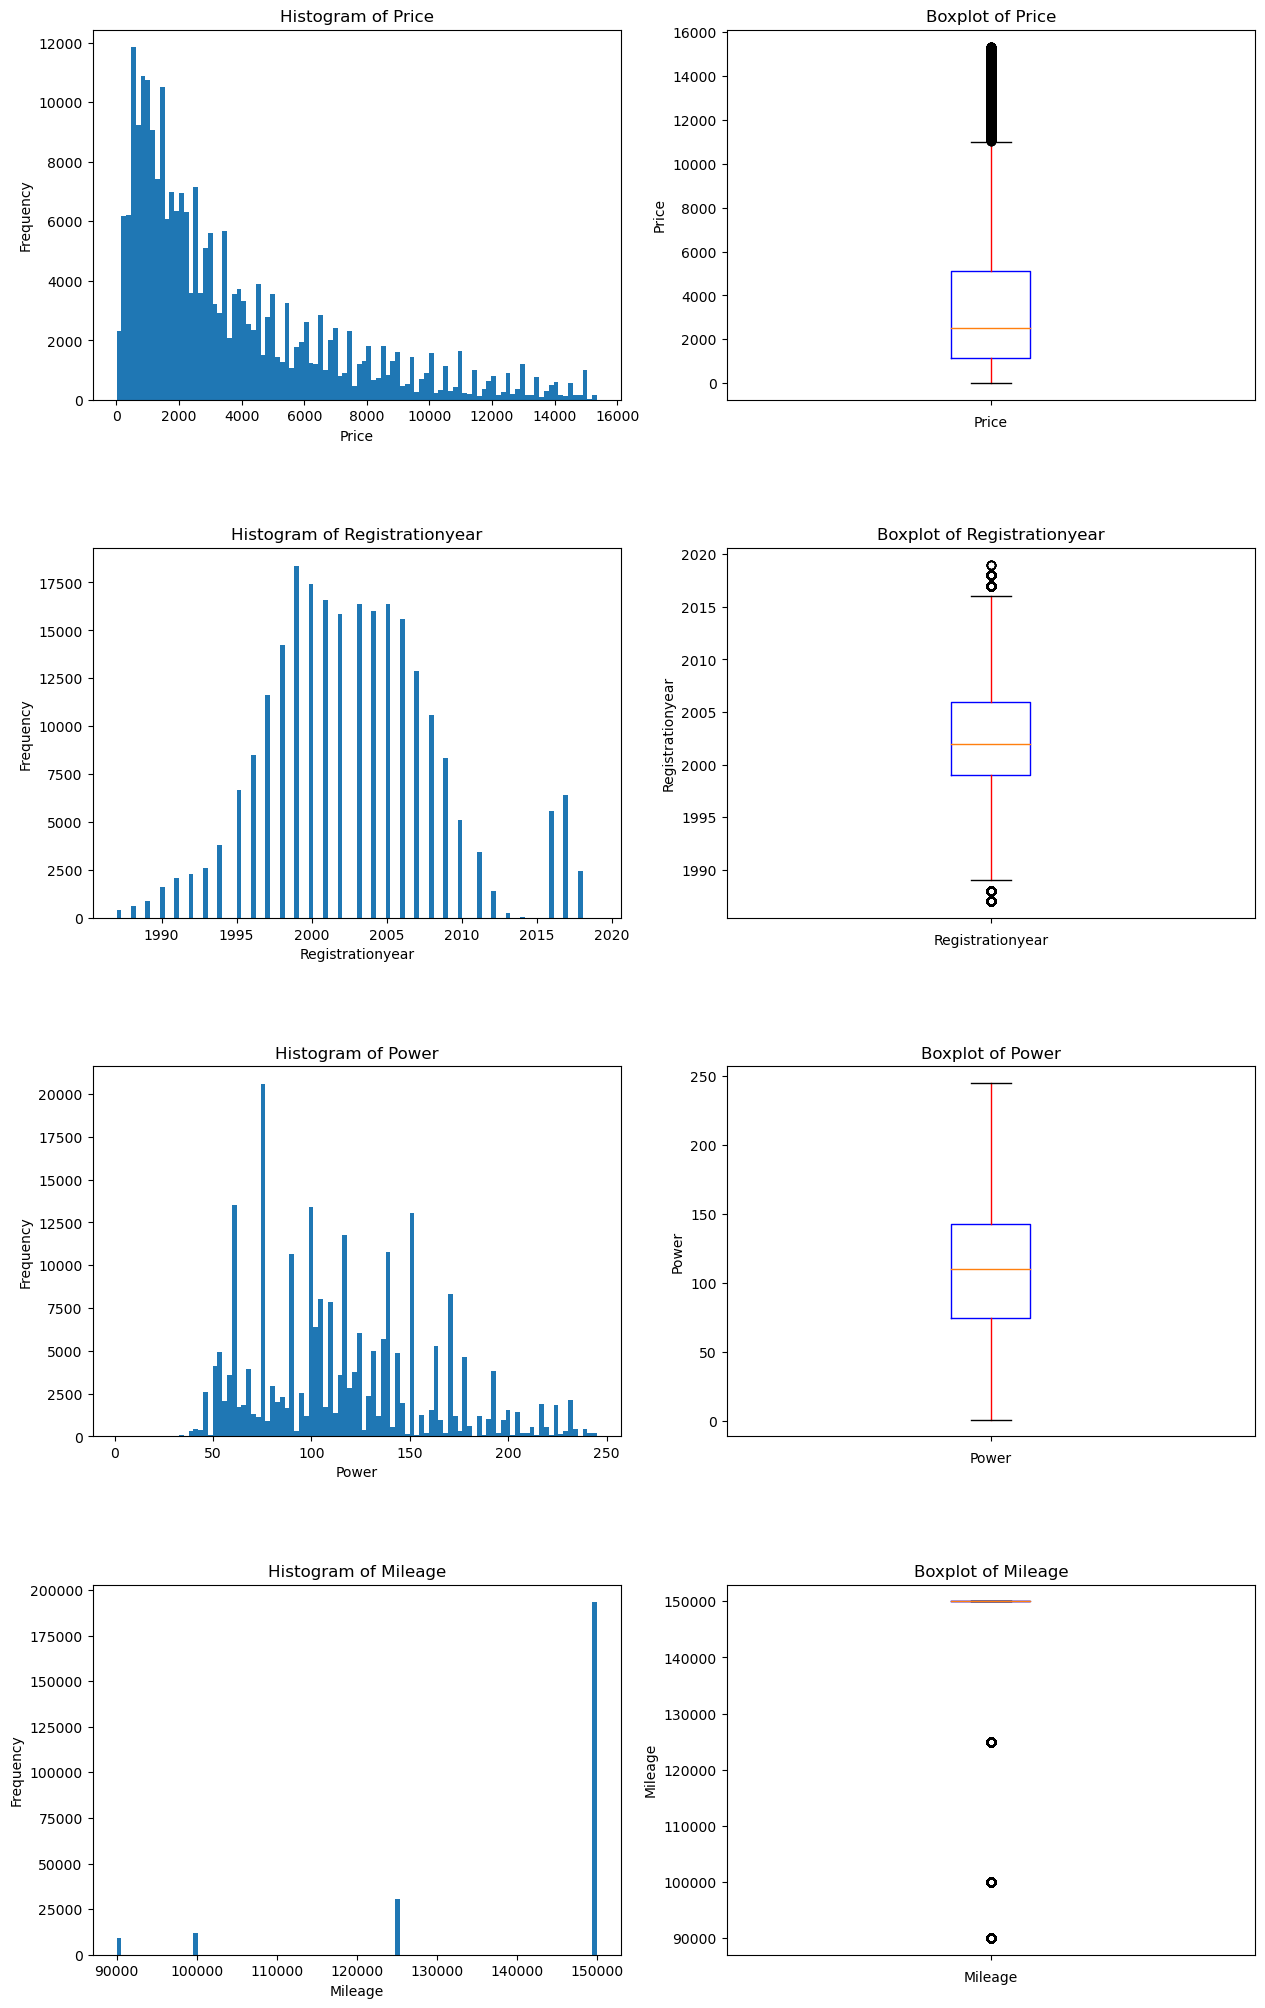

In [283]:
# Nueva verificación de distribuciones

# Creo la matriz de gráficos
fig, axes = plt.subplots(nrows=len(colums_with_outliers), ncols=2, figsize=(15, 25))


# Itero sobre las columnas y añado los gráficos a la matriz
for i, column in enumerate(colums_with_outliers):
    # Histograma en la primera columna
    axes[i, 0].hist(cars_filtered[column], bins=100)
    axes[i, 0].set_xlabel(column.capitalize())
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].set_title(f"Histogram of {column.capitalize().replace('_',' ')}")

    # Gráfico de caja en la segunda columna
    boxplot = axes[i, 1].boxplot(cars_filtered[column], boxprops={'color':'blue'}, whiskerprops={'color':'red'})
    axes[i, 1].set_ylabel(column.capitalize())
    axes[i, 1].set_title(f"Boxplot of {column.capitalize().replace('_',' ')}")
    axes[i, 1].set_xticklabels([])
    axes[i, 1].set_xlabel(column.capitalize())


plt.subplots_adjust(hspace=0.4)


plt.show()

In [284]:
# Revisión de las dimensiones de los datasets
print(f'Dataset original: {cars.shape}')
print(f'Dataset filtrado: {cars_filtered.shape}')

Dataset original: (354107, 11)
Dataset filtrado: (244671, 11)


Se obtiene como resultado un dataset más reducido con únicamente los valores de las columnas considerados como típicos.

Finalmente, se eliminan los valores de `registrationmonth` iguales a 0.

In [285]:
cars_filtered = cars_filtered.loc[cars_filtered['registrationmonth'] > 0]

In [286]:
cars_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227309 entries, 1 to 306276
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              227309 non-null  int64 
 1   vehicletype        213705 non-null  object
 2   registrationyear   227309 non-null  int64 
 3   gearbox            223946 non-null  object
 4   power              227309 non-null  int64 
 5   model              219793 non-null  object
 6   mileage            227309 non-null  int64 
 7   registrationmonth  227309 non-null  int64 
 8   fueltype           214798 non-null  object
 9   brand              227309 non-null  object
 10  notrepaired        195547 non-null  object
dtypes: int64(5), object(6)
memory usage: 20.8+ MB


Ya no existen valores NaN en las variables de tipo numérico. 

### <a id='toc2_4_'></a>[Valores ausentes](#toc0_)

In [287]:
print('Total de valores NaN por columna:')
print(cars_filtered.isna().sum())

Total de valores NaN por columna:
price                    0
vehicletype          13604
registrationyear         0
gearbox               3363
power                    0
model                 7516
mileage                  0
registrationmonth        0
fueltype             12511
brand                    0
notrepaired          31762
dtype: int64


Como se puede observar, únicamente las variables categóricas tienen valores ausentes. Estos serán imputados al reemplazar con las características del modelo de vehículo más frecuente en el dataset. 

In [288]:
cars_filtered['model'].value_counts().head(10)

golf        19881
3er         14886
other       13707
polo         8527
corsa        8100
passat       7661
astra        7533
a4           7490
c_klasse     6057
5er          5744
Name: model, dtype: int64

El modelo de vehículo más popular es el golf. No obstante, una importante cantidad de vehículos están registrados con la etiqueta "other". Dado que se desconoce qué tipo de vehículos son y, al considerar que la mayoría de variables categóricas dependen del modelo de vehículo, se decide eliminar los registros con dicha etiqueta debido a que podría traer errores en el análisis posterior. Se eliminan también los valores NaN.

In [289]:
# Se eliminan NaN y valores 'Other' de la columna 'model'
cars_filtered = cars_filtered.loc[(cars_filtered['model'].notnull()) & (cars_filtered['model'] != 'Other')]
cars_filtered.reset_index(drop=True, inplace=True)

In [290]:
# Se imputan NaNs de las columnas 'vehicletype' según el modelo más popular
cars_filtered['vehicletype'] = cars_filtered['vehicletype'].fillna(cars_filtered.groupby('model')['vehicletype'] \
                                                                                        .transform(lambda x: x.value_counts().index[0]))

In [291]:
# Se imputan NaNs de las columnas 'gearbox' según el modelo más popular
cars_filtered['gearbox'] = cars_filtered['gearbox'].fillna(cars_filtered.groupby('model')['gearbox'] \
                                                                                        .transform(lambda x: x.value_counts().index[0]))

In [292]:
# Se imputan NaNs de las columnas 'fueltype' según el modelo más popular
cars_filtered['fueltype'] = cars_filtered['fueltype'].fillna(cars_filtered.groupby('model')['fueltype'] \
                                                                                        .transform(lambda x: x.value_counts().index[0]))

Por último, queda a imputar la columna `notrepaired`. Dado que que esta variable no necesariamente depende del modelo de vehículo, no se puede utilizar el enfoque anterior. En lugar de ello, se estudiará la relación entre esta variable y el precio del vehículo.

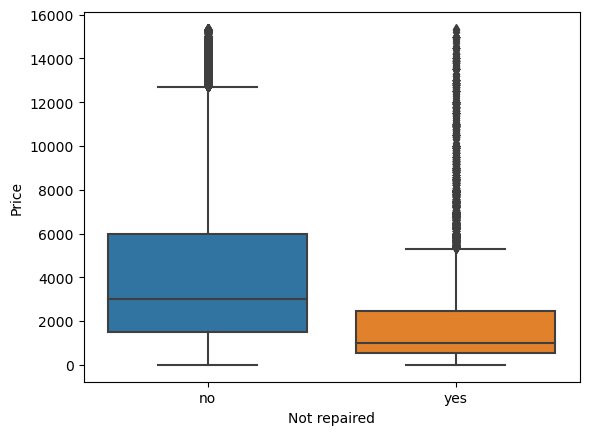

In [293]:
# Se crea un boxplot para visualizar la relación entre `price` y `notrepaired`
sns.boxplot(x='notrepaired', y='price', data=cars_filtered)
# cambiar el nombre de los ejes
plt.xlabel('Not repaired')
plt.ylabel('Price')
plt.show()

Según se observa en el gráfico, existen diferencias de precio entre los vehículos reparados y los no reparados. Se destaca que la mediana de los vehículos con la etiqueta `'yes'` es menor y está por debajo del rango intercuartílico de los vehículos con la etiqueta `'no'`, lo cual podría indicar una diferencia significativa entre los precios.

Se decide por lo tanto, rellenar los NaNs según el precio del vehículo, estableciendo que los vehículos con precio mayor a \$ 2500 llevarán la etiqueta `'no'` y los de precio menor o igual a $ 2500 llevarán la etiqueta `'yes'`.

In [294]:
# Función para rellenar valores nulos en `notrepaired` según el precio
def fill_notrepaired(row):
    if pd.notna(row['notrepaired']):
        return row['notrepaired']
    else:
        return 'no' if row['price'] > 2500 else 'yes'

# se aplica la función 

cars_filtered['notrepaired'] = cars_filtered.apply(fill_notrepaired, axis=1)

In [295]:
# se revisan nuevamente los valores nulos 
print('Total de valores NaN por columna:')
print(cars_filtered.isna().sum())

Total de valores NaN por columna:
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
dtype: int64


In [296]:
cars_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219793 entries, 0 to 219792
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              219793 non-null  int64 
 1   vehicletype        219793 non-null  object
 2   registrationyear   219793 non-null  int64 
 3   gearbox            219793 non-null  object
 4   power              219793 non-null  int64 
 5   model              219793 non-null  object
 6   mileage            219793 non-null  int64 
 7   registrationmonth  219793 non-null  int64 
 8   fueltype           219793 non-null  object
 9   brand              219793 non-null  object
 10  notrepaired        219793 non-null  object
dtypes: int64(5), object(6)
memory usage: 18.4+ MB


## <a id='toc3_'></a>[Entrenamiento del modelo](#toc0_)

In [298]:
# segmentación de los datos en los conjuntos feature y target
features = cars_filtered.drop(columns='price')
target = cars_filtered['price']

cars_features_num = features.select_dtypes(include=['int64', 'float64'])
cars_features_cat = features.select_dtypes(include=['object'])

cat_cols = cars_features_cat.columns.tolist()
num_cols = cars_features_num.columns.tolist()

print('Variables categóricas:')
print(cat_cols)
print('\nVariables numéricas:')
print(num_cols)

Variables categóricas:
['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

Variables numéricas:
['registrationyear', 'power', 'mileage', 'registrationmonth']


In [299]:
# Codificación One-Hot de las variables categóricas
ohe = OneHotEncoder(sparse = False, drop = "first") 
features_cat_ohe = pd.DataFrame(ohe.fit_transform(cars_features_cat), columns = ohe.get_feature_names_out())

# Se concatenan los datasets
features_ohe = pd.concat([features_cat_ohe, cars_features_num], axis = 1)

# Se separan los datos no OHE en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Se separan los datos OHE en conjuntos de entrenamiento y prueba
X_train_ohe, X_test_ohe = train_test_split(features_ohe, test_size=0.25, random_state=12345)


In [300]:
# Se revisan los tamaños de los conjuntos no OHE
print('Datos no OHE:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print('Datos OHE:')
print(X_train_ohe.shape, X_test_ohe.shape)

Datos no OHE:
(164844, 10) (164844,) (54949, 10) (54949,)
Datos OHE:
(164844, 301) (54949, 301)


In [310]:
# Escalado de características
# No OHE
X_train[num_cols] = StandardScaler().fit_transform(X_train[num_cols])
X_test[num_cols] = StandardScaler().fit_transform(X_test[num_cols])
# OHE
X_train_ohe[num_cols] = StandardScaler().fit_transform(X_train_ohe[num_cols])
X_test_ohe[num_cols] = StandardScaler().fit_transform(X_test_ohe[num_cols])

In [307]:

# Función para calcular el RMSE
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))


In [308]:
# Creación de dataframe para almacenar los resultados
model_data = pd.DataFrame(columns=['model', 'fit_time', 'score_time', 'RMSE'])
model_data.head()

,model,fit_time,score_time,RMSE


### <a id='toc3_1_'></a>[Regresión lineal](#toc0_)

In [311]:

lr_row = ['LinearRegression']

model = LinearRegression()
# entrenamiento del modelo y cálculo del tiempo
start = time.time()
model.fit(X_train_ohe, y_train)
end = time.time()

lr_row.append(end - start)
# predicción y cálculo del tiempo
start = time.time()
y_pred = model.predict(X_test_ohe)
end = time.time()

lr_row.append(end - start)

# cálculo del RMSE
lr_rmse = rmse(y_test, y_pred)
lr_row.append(lr_rmse)

# se añade la fila de resultados al dataframe
model_data.loc[0] = lr_row
model_data.head()

,model,fit_time,score_time,RMSE
0,LinearRegression,4.413509,0.181779,1942.416997


### <a id='toc3_2_'></a>[Random Forest](#toc0_)

In [312]:

rf_model = RandomForestRegressor(random_state=12345, n_estimators=10)

# Se aplica cross-validation con 5 folds 
cv = cross_validate(rf_model, X_train_ohe, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
# se generan los resultados
avg_fit_time = cv['fit_time'].mean()
avg_score_time = cv['score_time'].mean()
avg_rmse = math.sqrt(-cv['test_score'].mean())

rf_row = ['RandomForestRegressor', avg_fit_time, avg_score_time, avg_rmse]

# se añade la fila de resultados al dataframe
model_data.loc[1] = rf_row
model_data.head()


,model,fit_time,score_time,RMSE
0,LinearRegression,4.413509,0.181779,1942.416997
1,RandomForestRegressor,31.515265,0.230582,1294.881320


### <a id='toc3_3_'></a>[LightGBM](#toc0_)

In [315]:
# Se convierten las variables categóricas a tipo 'category'
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [334]:
# Parámetros para el GridSearch
params = {'num_leaves': [10,31],
            'max_depth': [-1, 15], 
            'learning_rate': [0.01, 0.5]}

# Se aplica GridSearch 
lgbm_grid = GridSearchCV(LGBMRegressor(), params, cv=5, scoring='neg_mean_squared_error')

# Se entrena el modelo
lgbm_model = lgbm_grid.fit(X_train, y_train)
print()
print(lgbm_model.best_params_, math.sqrt(-lgbm_model.best_score_))



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 131875, number of used features: 10
[LightGBM] [Info] Start training from score 3790.056190
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 131875, number of used features: 10
[LightGBM] [Info] Start training from score 3799.711439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

In [333]:
# Información de los resultados
results = lgbm_model.cv_results_
# índice del mejor modelo
best_index = lgbm_model.best_index_
# se extraen los tiempos y el RMSE del mejor modelo
fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = math.sqrt(-lgbm_model.best_score_)

# se añade la fila de resultados al dataframe
lgbm_row = ['LGBMRegressor', fit_time, score_time, RMSE]

model_data.loc[2] = lgbm_row
model_data.head()

,model,fit_time,score_time,RMSE
0,LinearRegression,4.413509,0.181779,1942.416997
1,RandomForestRegressor,31.515265,0.230582,1294.881320
2,LGBMRegressor,0.726819,0.119692,1245.652708


## <a id='toc4_'></a>[Análisis de modelos](#toc0_)

Como se puede observar, el modelo que mejor se ajusta a los datos es el LGBMRegressor, con un RMSE de 1245.65, seguido por el RandomForestRegressor con un RMSE de 1294.88. Adicionalmente, la velocidad de predicción del modelo LGBMRegressor es la más rápida, incluso más que el modelo de regresión lineal, el cual obtuvo el RMSE más bajo, lo que también indica que los otros modelos pasaron la prueba de cordura. Se concluye por lo tanto que el modelo LGBMRegressor es el más adecuado para este caso.